In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt

### data generation functions

In [2]:
def gen_r(r_min, r_max, dr):
    return np.arange(r_min, r_max, dr).reshape(-1, 1)

def perturb(vals, minimum, maximum, perturb_delta):
    # add noise to vals
    noise = torch.randn_like(vals) * perturb_delta
    new_vals = vals + noise
    
    # if perturbed vals fall outside of vals domain, move them back in
    new_vals.data[new_vals < minimum] = minimum - new_vals.data[new_vals < minimum]  
    new_vals.data[new_vals > maximum] = 2 * maximum - new_vals.data[new_vals > maximum]  

    return new_vals

def perturb_data(data, perturb_delta=0.01):
    new_data = torch.ones_like(data)
    minimums = [torch.min(data[:, i]).item() for i in range(data.shape[1])]
    maximums = [torch.max(data[:, i]).item() for i in range(data.shape[1])]
    perturb_deltas = [(torch.max(data[:, i]) - torch.min(data[:, i])).item() * perturb_delta for i in range(data.shape[1])]

    for i in range(data.shape[1]):
        new_data[:, i] = perturb(data[:, i], minimums[i], maximums[i], perturb_delta=perturb_deltas[i])

    return new_data

### generate and check data

In [3]:
# set gpu
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

r_min = 0.1
r_max = 40
dr = 0.01
data = torch.tensor(gen_r(r_min, r_max, dr), requires_grad=True).to(device)

In [4]:
def plot_r_hist(data):
    data_d = data.detach().cpu().numpy()
    plt.hist(data_d)

    plt.xlabel("r")
    plt.ylabel("count")
    plt.show()

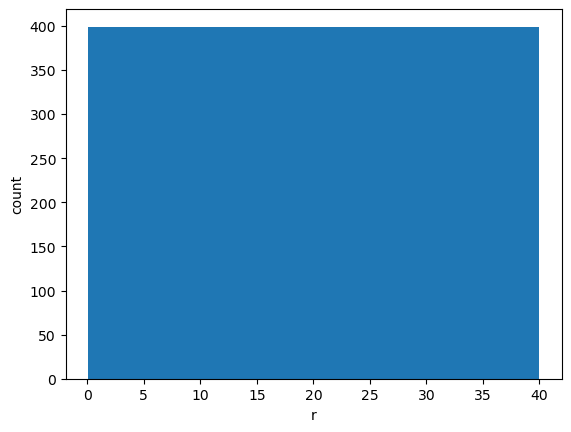

In [5]:
plot_r_hist(data)

### loss class definition

In [6]:
class PINNLoss(nn.Module):
    def __init__(self):
        super(PINNLoss, self).__init__()
        self.loss = None

        # NOTE if you change loss terms returned, must change this and return+calculations in calc_loss()
        self.return_names = ["loss_ovr", "loss_f", "u_trivial_penalty"]
    
    def MSE_f(self, f_pred):
        """
        Returns MSE loss on f predictions. 

        Inputs:
        f_pred: batch of differential equation predictions
        """

        return torch.mean(f_pred**2)

    def calc_u_trivial_penalty(self, u_pred):
        """
        Returns a term that penalizes trivial solutions.

        Inputs:
        u_pred: batch of wavefunction predictions
        """

        return 1 / torch.mean(u_pred**2 + 1e-6)

    def calc_loss(self, u_pred, f_pred):
        """
        Calculate loss terms for predictions. Returns a tuple of losses. 
        Names and order of returned terms should match self.return_names.

        Inputs:
        u_pred: batch of wavefunction predictions 
        f_pred: batch of differential equation predictions
        """

        # differential equation MSE loss
        loss_f = self.MSE_f(f_pred)

        # trivial solution penalty 
        u_trivial_penalty = self.calc_u_trivial_penalty(u_pred)

        # overall loss
        loss_ovr = loss_f + u_trivial_penalty 

        return loss_ovr, loss_f, u_trivial_penalty

### PINN class definition

In [ ]:
class SinActivation(torch.nn.Module):
    @staticmethod
    def forward(input):
        """
        Passes input tensor through sin function. Used in neural network class.

        Inputs:
        input: tensor batch of layer outputs
        """

        return torch.sin(input)

class PINN(nn.Module):
    def __init__(self, input_size, device, r_max, num_hidden_layers=4, init_E=None, optimizer_lr=0.0001, optimizer_betas=(0.999, 0.9999)):
        super(PINN, self).__init__()

        # constants
        self.planck_term_constant = 0.5  # Coulomb units 
        self.charge_term_constant = 1  # Coulomb units 

        # maximum r in data
        self.r_max = r_max

        # torch device
        self.device = device

        # E initialization
        self.E = init_E 

        # network
        self.activation = SinActivation()
        self.dense0 = nn.Linear(input_size + 1, 64, dtype=torch.double)  # NOTE +1 to input shape for implicit E value
        self.hidden_layers = nn.ModuleList([nn.Linear(64, 64, dtype=torch.double) for _ in range(num_hidden_layers)])  # NOTE new
        self.dense_out = nn.Linear(64, 1, dtype=torch.double)

        # optimizer + loss
        self.optimizer = optim.Adam(self.parameters(), lr=optimizer_lr, betas=optimizer_betas)
        self.loss_criteria = PINNLoss()
        self.loss = None

    def forward_net(self, data):
        """
        Forward pass through full network. Returns network output.

        Inputs:
        data: tensor with correct input shape
        """

        out = self.dense0(data)
        out = self.activation(out)

        for hidden_layer in self.hidden_layers:
            out = hidden_layer(out)
            out = self.activation(out)

        out = self.dense_out(out)
        
        return out

    def scale_output(self, r, u):
        """
        Scales output to satisfy boundary condition u->0 as r->inf

        Inputs:
        r: radius data
        u: network output
        """

        scale = (1 - torch.exp(r - self.r_max))

        return u * scale

    def forward(self, r):
        """
        Full PINN forward pass that includes E concat, network forward pass, network output b.c. scaling, 
        gradient calculations, and diff. eqn. (f) calculation.
        Returns final output prediction, u, and f.

        Inputs:
        r: tensor of r with shape (N, 1)
        """

        # create E input vector
        E_batch = torch.tensor([[self.E]] * r.shape[0]).to(self.device)

        # concat inputs for network (need them separate initially for grad calc later)
        nn_inp = torch.cat([r, E_batch], dim=1)

        # pass through nn
        u = self.forward_net(nn_inp)

        # scale output 
        u = self.scale_output(r, u)

        # calc gradients
        u_r = torch.autograd.grad(u, r, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_rr = torch.autograd.grad(u_r, r, grad_outputs=torch.ones_like(u_r), retain_graph=True, create_graph=True)[0]
        #u_rr = torch.autograd.grad(r**2 * u_r, r, grad_outputs=torch.ones_like(u_r), retain_graph=True, create_graph=True)[0]

        # differential equation (NOTE assumes l=0)
        f = -self.planck_term_constant * u_rr - u * ((1/r) + self.E)

        return u, f

    def forward_inference(self, r):
        """
        Inference forward pass. Doesn't include gradient + f calculation.

        Inputs:
        r: tensor of r with shape (N, 1)
        """

        # create E input vector
        E_batch = torch.tensor([[self.E]] * r.shape[0]).to(self.device)

        # concat inputs for network 
        nn_inp = torch.cat([r, E_batch], dim=1)

        # pass through nn
        u = self.forward_net(nn_inp)

        # scale output 
        u = self.scale_output(r, u)

        return u

    def backward(self, u_pred, f_pred):
        """
        Network backward pass. Returns tuple of loss values.
        
        Inputs:
        u_pred: batch of wavefunction predictions 
        f_pred: batch of differential equation predictions
        """

        # calculate losses
        losses = self.loss_criteria.calc_loss(u_pred, f_pred)
        self.loss = losses[0]  # NOTE overall loss should always be first value returned in losses tuple

        # backprop + update params
        self.loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

        return losses 

### plot functions

In [8]:
def display_plot(x_vals, y_vals, x_label="x", y_label="y", line_color="b", log_scale=False, data_label=None, title=None):
    """
    Generate plot for x_vals and y_vals.

    Inputs:
    pretty self-explanatory
    """

    if data_label:
        plt.plot(x_vals, y_vals, color=line_color, label=data_label)
        plt.legend()
    else:
        plt.plot(x_vals, y_vals, color=line_color)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    if log_scale:
        plt.yscale("log")

    plt.show()

### main train loop

In [ ]:
def run_train_loop(data, 
                   device, 
                   r_max, 
                   E_range,
                   num_train_steps_per_E,
                   save_denom=1000,
                   loss_criteria_idx=0,
                   num_hidden_layers=4):
    start_time = time.time()
    print(f"training network on {len(E_range)} values of E with {num_train_steps_per_E} train steps per E...")
    epoch = 0
    epoch_print_denom = 1000

    # initialize network
    lr = 8e-3
    betas = (0.999, 0.9999)
    pinn = PINN(data.shape[1], device, r_max, 
                optimizer_lr=lr, optimizer_betas=betas, 
                num_hidden_layers=num_hidden_layers)
    pinn.to(device)

    # best model save variables
    min_save_epoch = 100
    prev_pinns = []  # list to store best models 
    default_min_loss = 1000
    min_loss = default_min_loss
    current_best_epoch = -1

    E_predictions = []  # track E by training step (epoch)
    train_loss_vals = []  # track all loss values across training

    for E_idx, E in enumerate(E_range):
        pinn.E = E
        
        for train_step in range(num_train_steps_per_E):

            # perturb data
            #perturbed_data = perturb_data(data).to(device)
            perturbed_data = data

            # forward pass
            u_pred, f_pred = pinn.forward(perturbed_data)

            # backward pass
            losses = pinn.backward(u_pred, f_pred)
            train_loss_vals.append([loss_val.item() for loss_val in losses])

            # track E
            E_predictions.append(E)
            
            # check if new minimum overall loss attained across this window of epochs
            if (epoch >= min_save_epoch) and (losses[loss_criteria_idx] < min_loss):
                # update current best loss and epoch
                min_loss = losses[loss_criteria_idx]
                current_best_epoch = epoch
                
                # copy current model state 
                current_best_pinn = PINN(data.shape[1], device, r_max, init_E=pinn.E, optimizer_lr=lr, optimizer_betas=betas, 
                                         num_hidden_layers=num_hidden_layers).to(device)
                current_best_pinn.load_state_dict(pinn.state_dict())

            # save the best (min ovr loss) model across this window of epochs
            if (epoch >= min_save_epoch) and ((epoch + 1) % save_denom == 0):
                min_loss = default_min_loss  # reset min loss to default (ideally next best model beats quickly) 

                # copy current model state and save (model, epoch) tuple to list
                pinn_copy = PINN(data.shape[1], device, r_max, init_E=current_best_pinn.E, optimizer_lr=lr, optimizer_betas=betas, 
                                 num_hidden_layers=num_hidden_layers).to(device)
                pinn_copy.load_state_dict(current_best_pinn.state_dict())
                prev_pinns.append((pinn_copy, current_best_epoch))

            if ((epoch == 0) or ((epoch + 1) % epoch_print_denom == 0)):
                print("\n" + "=" * 20 + f" EPOCH {epoch} " + "=" * 20)
                print()
                print("train losses:")
                for return_name, val in zip(pinn.loss_criteria.return_names, train_loss_vals[epoch]):
                    print(f"{return_name} = {val:.3e}")
                print()
                print(f"current E = {pinn.E.item()}")
                print(f"elapsed model training time: {(time.time() - start_time) / 60 :.2f} minutes")

            epoch += 1

    # plot losses
    epoch_list = [e for e in range(epoch)]
    for loss_idx, loss_name in enumerate(pinn.loss_criteria.return_names):
        display_plot(epoch_list,
                     torch.tensor(train_loss_vals)[:, loss_idx].detach().numpy(),
                     x_label="epoch",
                     y_label=loss_name,
                     log_scale=True)

    # plot E
    display_plot(epoch_list, E_predictions, x_label="epoch", y_label=r"$\hat{E}$")

    return prev_pinns, train_loss_vals, epoch

### train model

In [10]:
for n in range(1, 10):
    ev = -13.6 / n**2
    columb_E = -1 / (2 * n**2)
    print(f"E (eV) = {-13.6 / n**2}, E (coulomb units) = {columb_E}")

E (eV) = -13.6, E (coulomb units) = -0.5
E (eV) = -3.4, E (coulomb units) = -0.125
E (eV) = -1.511111111111111, E (coulomb units) = -0.05555555555555555
E (eV) = -0.85, E (coulomb units) = -0.03125
E (eV) = -0.544, E (coulomb units) = -0.02
E (eV) = -0.37777777777777777, E (coulomb units) = -0.013888888888888888
E (eV) = -0.27755102040816326, E (coulomb units) = -0.01020408163265306
E (eV) = -0.2125, E (coulomb units) = -0.0078125
E (eV) = -0.16790123456790124, E (coulomb units) = -0.006172839506172839


In [11]:
E_ranges = [np.arange(-0.7, -0.3, 0.1), np.arange(-0.2, -0.08, 0.025), np.arange(-0.07, -0.03, 0.01)]

E_range = []
for Er in E_ranges:
    for E in Er:
        E_range.append(E)

num_train_steps_per_E = 10000

max_epoch_per_E = []
prev_max = 0
for Er in E_ranges:
    max_epoch = prev_max + len(Er) * num_train_steps_per_E
    prev_max = max_epoch
    max_epoch_per_E.append(max_epoch)

In [12]:
E_range

[-0.7,
 -0.6,
 -0.5,
 -0.4,
 -0.2,
 -0.17500000000000002,
 -0.15000000000000002,
 -0.12500000000000003,
 -0.10000000000000003,
 -0.07,
 -0.060000000000000005,
 -0.05,
 -0.04,
 -0.03]

training network on 3 values of E with 10000 train steps per E...

==================== EPOCH 0 ====================

train losses:
loss_ovr = 9.282e+01
loss_f = 4.166e-03
u_trivial_penalty = 9.281e+01

current E = -0.5
elapsed model training time: 0.01 minutes

==================== EPOCH 999 ====================

train losses:
loss_ovr = 1.492e-01
loss_f = 9.255e-02
u_trivial_penalty = 5.669e-02

current E = -0.5
elapsed model training time: 0.23 minutes

==================== EPOCH 1999 ====================

train losses:
loss_ovr = 5.383e-02
loss_f = 2.560e-02
u_trivial_penalty = 2.824e-02

current E = -0.5
elapsed model training time: 0.45 minutes

==================== EPOCH 2999 ====================

train losses:
loss_ovr = 2.753e-02
loss_f = 7.177e-03
u_trivial_penalty = 2.036e-02

current E = -0.5
elapsed model training time: 0.66 minutes

==================== EPOCH 3999 ====================

train losses:
loss_ovr = 2.026e-02
loss_f = 2.261e-03
u_trivial_penalty = 1.800e-02

cu

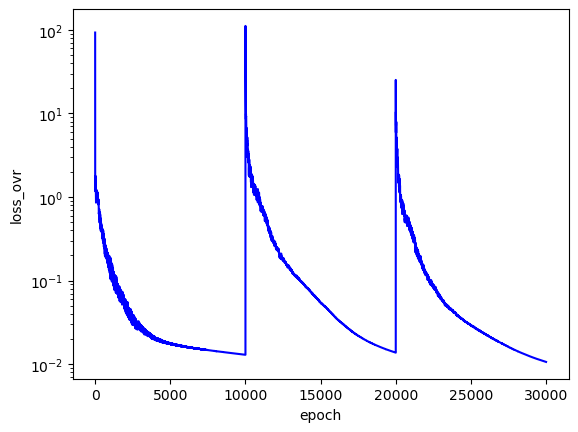

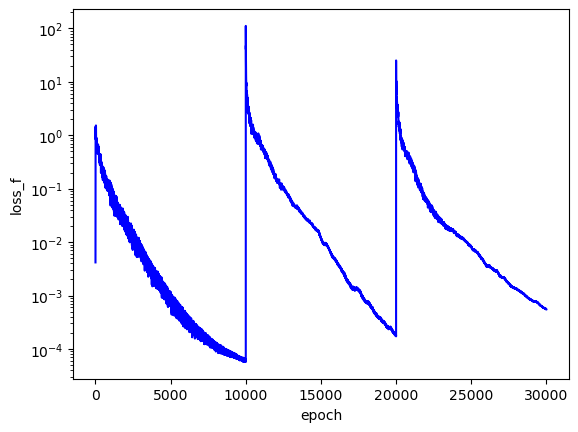

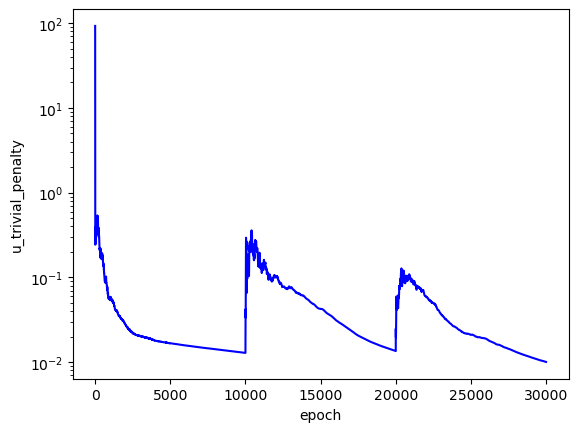

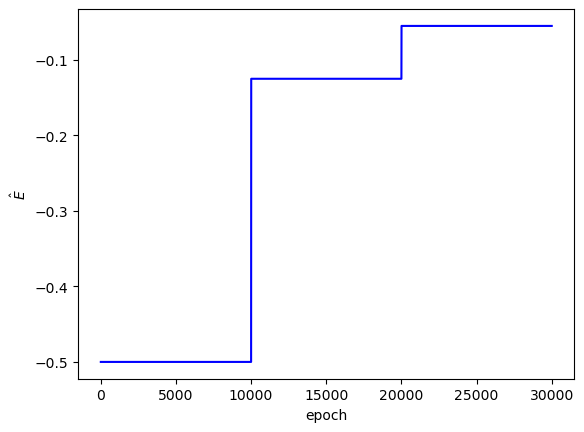

In [ ]:
E_range = np.array([-0.5, -0.125, -0.055])  # NOTE overwriting above just for getting outputs on this train run
loss_criteria_idx = 1
saved_pinns, train_loss_vals, num_epochs = run_train_loop(data, device, r_max, E_range, num_train_steps_per_E, 
                                                          loss_criteria_idx=loss_criteria_idx, num_hidden_layers=2)

In [14]:
def get_best_pinns(min_loss_windows, pinns, train_loss_vals, loss_criteria_idx):
    """
    Plots model with minimum loss (based on loss_criteria_idx) in each window of min_loss_windows.
    Returns list of dictionaries containing the best models + relevant info.

    Inputs:
    min_loss_windows: list of tuples where each tuple is a range of epoch values to look for model with minimum loss
    pinns: list of all saved torch models across training
    train_loss_vals: list of tuples containing loss values for each training epoch
    loss_criteria_idx: index of loss term to use for evaluating best model to save (see PINNLoss)
    """

    ovr_losses = torch.tensor(train_loss_vals)[:, loss_criteria_idx].detach().numpy()
    eigen_pinns = []  # list to save best models to (assuming each model saved below corresponds to unique eigenvalue)

    for (start, stop) in min_loss_windows:
        # find the epoch where the minimum overall loss is achieved
        epoch_idx = np.argmin(ovr_losses[start:stop]) + start

        if (len(pinns) == 0):
            print("No models saved during training.")
        else:
            # get the matching model (this should always hit i think as long as there is a match)
            p_list = [(net, epoch_num) for (net, epoch_num) in pinns if epoch_num == epoch_idx]

            if (len(p_list) == 0):
                print(f"No matching saved models found for epoch window [{start}, {stop}] with minimum epoch = {epoch_idx}. Check self-defined minimum loss windows.")
            else:
                # matching model found
                p = p_list[0]
                
                # save this predicted eigen solution
                eigen_pinns.append({"model": p[0], "epoch": epoch_idx, "losses": train_loss_vals[epoch_idx]})
    
    return eigen_pinns

In [ ]:
loss_windows = [[i*num_train_steps_per_E, i*num_train_steps_per_E + num_train_steps_per_E] for i in range(num_epochs // num_train_steps_per_E)]
best_pinns = get_best_pinns(loss_windows, saved_pinns, train_loss_vals, loss_criteria_idx)

for i, best_pinn in enumerate(best_pinns):
    best_pinn["n"] = i + 1

In [16]:
loss_windows

[[0, 10000], [10000, 20000], [20000, 30000]]

In [17]:
best_pinns

[{'model': PINN(
    (activation): SinActivation()
    (dense0): Linear(in_features=2, out_features=64, bias=True)
    (hidden_layers): ModuleList(
      (0-1): 2 x Linear(in_features=64, out_features=64, bias=True)
    )
    (dense_out): Linear(in_features=64, out_features=1, bias=True)
    (loss_criteria): PINNLoss()
  ),
  'epoch': 9986,
  'losses': [0.012964122232810469,
   5.710543591530069e-05,
   0.012907016796895168],
  'n': 1},
 {'model': PINN(
    (activation): SinActivation()
    (dense0): Linear(in_features=2, out_features=64, bias=True)
    (hidden_layers): ModuleList(
      (0-1): 2 x Linear(in_features=64, out_features=64, bias=True)
    )
    (dense_out): Linear(in_features=64, out_features=1, bias=True)
    (loss_criteria): PINNLoss()
  ),
  'epoch': 19998,
  'losses': [0.013743605044299141,
   0.00017209739492967852,
   0.013571507649369463],
  'n': 2},
 {'model': PINN(
    (activation): SinActivation()
    (dense0): Linear(in_features=2, out_features=64, bias=True)
 

In [19]:
def calc_R_prob_density(r, R):
    """
    Calculates the probability density of R 
    
    Inputs:
    """
    
    return 4 * np.pi * r**2 * R**2

def calc_R_10(r, bohr_radius):
    return 2 * bohr_radius**(-1.5) * np.exp(-r / bohr_radius)

def calc_R_20(r, bohr_radius):
    return (1 / (np.sqrt(2))) * bohr_radius**(-1.5) * (1 - 0.5*(r / bohr_radius)) * np.exp(-r / (2 * bohr_radius))

def calc_R_30(r, bohr_radius):
    return (2 / (3 * np.sqrt(3))) * bohr_radius**(-1.5) * (1 - (2/3)*(r/bohr_radius) + (2/27)*(r/bohr_radius)**2) * np.exp(-r / (3 * bohr_radius))
    
def calc_pred_norm_const(approx_r_domain_u_pred_vec, dr):
    return 1. / torch.sqrt(dr * torch.sum(approx_r_domain_u_pred_vec**2))

In [ ]:
def eval_pinn(pinn_dict, r_data):
    print("=" * 100)
    print(f"PINN saved on epoch {pinn_dict['epoch']}")
    print(f"E = {pinn_dict['model'].E}")
    
    for loss_val, loss_name in zip(pinn_dict["losses"], pinn_dict["model"].loss_criteria.return_names):
        print(f"{loss_name} = {loss_val}")

    n = pinn_dict["n"]
    bohr_radius = 1  # coulomb units

    # make predictions
    pinn = pinn_dict["model"]
    u_pred = pinn.forward_inference(r_data)
    u_pred = u_pred.flatten().detach().cpu().numpy()
    r = r_data.detach().cpu().numpy().flatten()

    # R analytical
    if n == 1:
        R_analytical = calc_R_10(r, bohr_radius)
    elif n == 2:
        R_analytical = calc_R_20(r, bohr_radius)
    else:
        R_analytical = calc_R_30(r, bohr_radius)

    R_prob_densities = calc_R_prob_density(r, R_analytical)

    # prediction normalization constant on u
    dr = r[1] - r[0]
    approx_r_domain = torch.tensor(np.arange(r.min(), r.max(), dr)).to(device).reshape(-1, 1)
    approx_r_domain_u_pred_vec = pinn.forward_inference(approx_r_domain)
    pred_norm_const = calc_pred_norm_const(approx_r_domain_u_pred_vec, dr).item()
    u_pred = u_pred * pred_norm_const

    # get R from u
    R_pred = u_pred / r

    # hacky check for negative predictions
    flip_pre = np.mean(R_analytical / R_pred)
    flip_val = int(np.round(flip_pre))
    if (flip_val < 0):
        flipped_sign = True
        R_pred = -R_pred
    else:
        flipped_sign = False

    R_pred_prob_densities = calc_R_prob_density(r, R_pred)

    print(f"flipped sign = {flipped_sign}, rounded flip val = {flip_val}, pre-round = {flip_pre}")
    print(f"most likely r: {r[np.argmax(R_pred_prob_densities)]}")
    print(f"MSE = {np.mean(np.sum((R_analytical - R_pred)**2))}")

    # R vs. r plot
    plt.plot(r, R_pred, label="prediction", color="b")
    plt.plot(r, R_analytical, label="analytical", color="r", ls="--")
    plt.xlabel("r")
    plt.ylabel("R")
    plt.legend()
    plt.show()
    
    # r prob density plot
    plt.close()  
    plt.plot(r, R_pred_prob_densities * bohr_radius, label="prediction", color="b")
    plt.plot(r, R_prob_densities * bohr_radius, label="analytical", color="r", ls="--")
    plt.title("radial probability density")
    plt.xlabel("r")
    plt.ylabel(rf"$4\pi$$r^2R{n}0(r)^2$")
    plt.legend()
    plt.show()
    
    # f values plot
    plt.close()
    _, f_pred = pinn.forward(r_data)
    f_pred = f_pred.detach().cpu().numpy()
    plt.scatter(r, f_pred, color="b", s=5)
    plt.xlabel("r")
    plt.ylabel("f")
    plt.yscale("log")
    plt.show()

PINN saved on epoch 9986
E = -0.5
loss_ovr = 0.012964122232810469
loss_f = 5.710543591530069e-05
u_trivial_penalty = 0.012907016796895168
flipped sign = False, rounded flip val = 0, pre-round = 0.23684237492761454
most likely r: 0.9999999999999996
MSE = 3.5283948188316675e-05


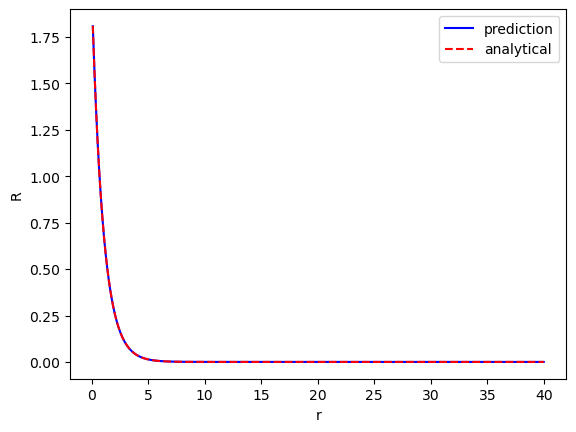

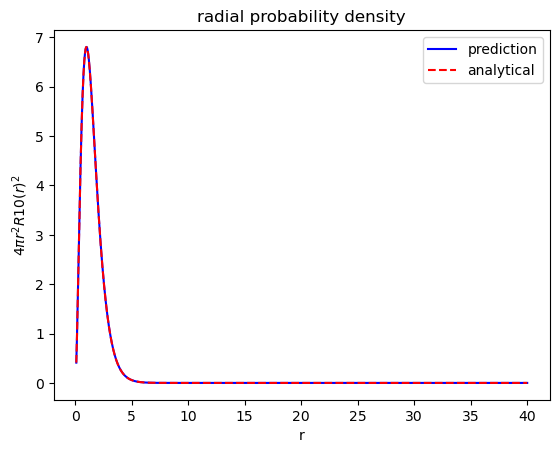

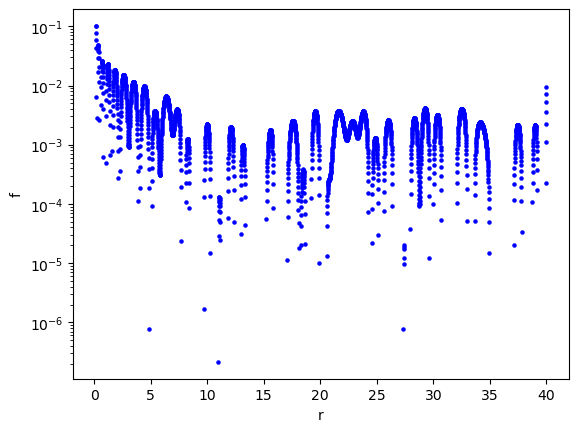

PINN saved on epoch 19998
E = -0.125
loss_ovr = 0.013743605044299141
loss_f = 0.00017209739492967852
u_trivial_penalty = 0.013571507649369463
flipped sign = True, rounded flip val = -1, pre-round = -0.6438851466037014
most likely r: 5.299999999999997
MSE = 0.014504907390374156


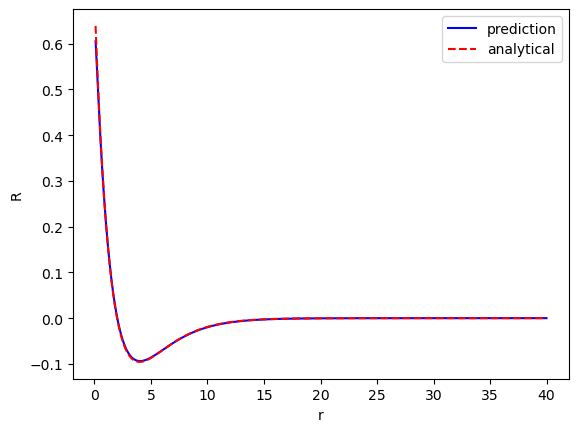

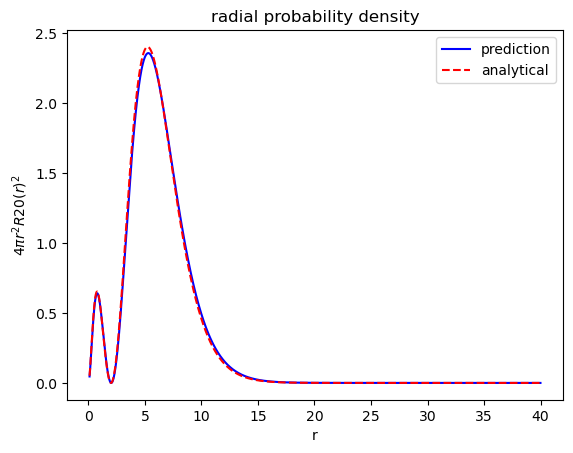

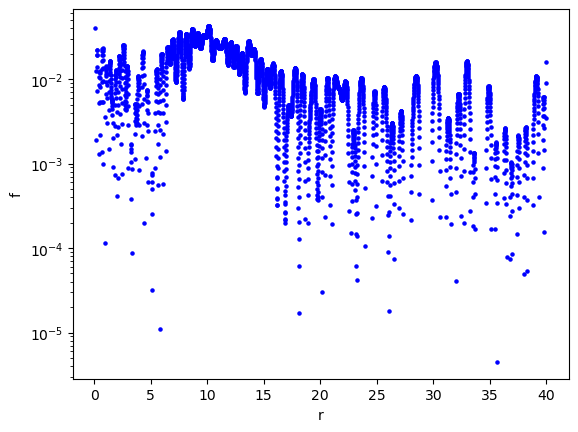

PINN saved on epoch 29999
E = -0.055
loss_ovr = 0.010644964559850287
loss_f = 0.000552109096213118
u_trivial_penalty = 0.01009285546363717
flipped sign = False, rounded flip val = 1, pre-round = 1.1963111610329005
most likely r: 13.869999999999992
MSE = 0.2325084845788365


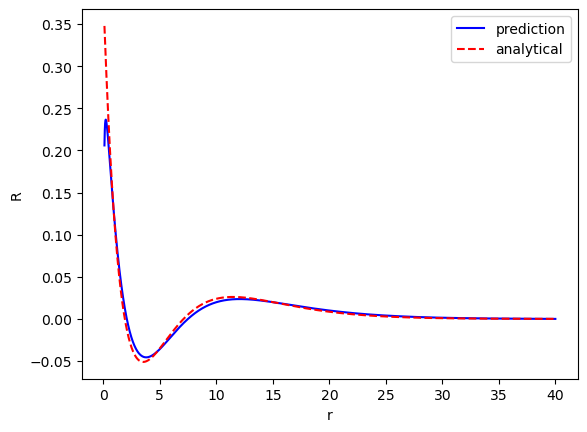

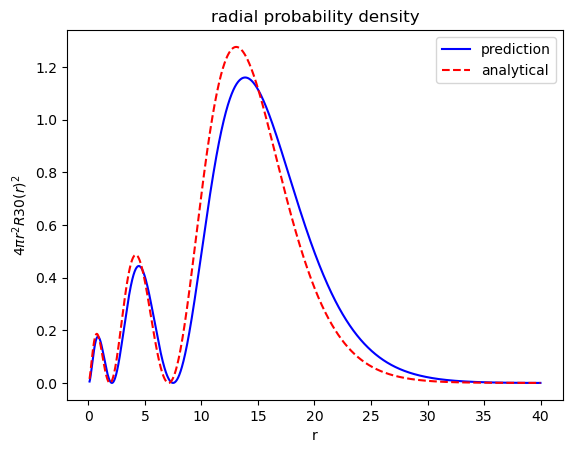

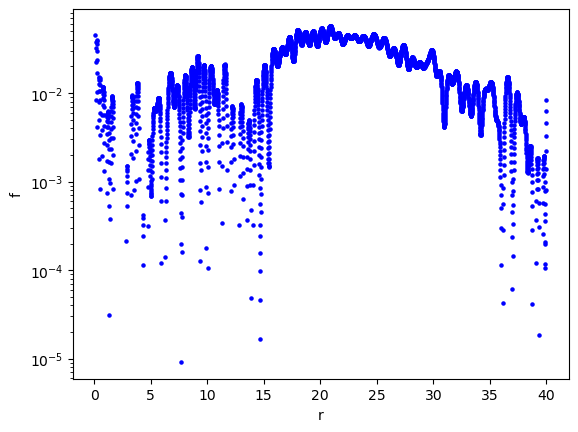

In [21]:
for pinn_dict in best_pinns:
    eval_pinn(pinn_dict, data)